# E Cigarette Smoke Free Indoor Air Clustering

## ML Assignment 2 : Clusetring with GMM

### [Google Drive Dataset Link](https://drive.google.com/open?id=14OlNrJvCG8YUnaovZD2uMpySM5UD-A1V) 

### Course code : CMPE-257
### Author: Sudha Amarnath (013709956)



The STATE System houses current and historical state-level legislative data on tobacco use prevention and control policies. Data are reported on a quarterly basis. Data include information related to state legislation on smokefree indoor air in areas such as: Bars, Commercial Day Care Centers, Government Multi-Unit Housing, Government Worksites, Home-Based Day Care Centers, Hotels and Motels, Personal Vehicles, Private Multi-Unit Housing, Private Worksites, Restaurants, Bingo Halls, Casinos, Enclosed Arenas, Grocery Stores, Hospitals, Hospital Campuses, Malls, Mental Health Outpatient and Residential Facilities, Prisons, Public Transportation, Racetrack Casinos, Substance Abuse Outpatient and Residential Facilities.


As for the vaping trend analysis, we want to know what kinds of provision locations the e-cigarette trend is high for a given province. In this way, we could find where the e-cigarette smoking is banned, allowed of if there are any fines in the province. 


Following steps are done to arrive at the business conclusion.
1. Preparing the dataset
2. Identifying number of columns for clustering
3. Find the optimum clusters using Elbow method
4. Applying GMM clustering with Scikit Learn
5. Applying K-means clustering using Tensor Flow
6. Applying K-means, Mini Batch KMeans clustering using Scikit Learn
7. Comparing Metrics between the algorithms
8. Analysing the resultant clusters
9. Bar chart plots to compare cluseters
9. Visualizing restricted count using state wise map


### Importing Required Libraries

In [0]:
# Author: Sudha Amarnath <sudha.amarnath@sjsu.edu>

import random
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import sklearn.cluster.k_means_
import tensorflow as tf
import seaborn as sns
import plotly.graph_objects as go

from time import time
from sklearn import mixture
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
%matplotlib inline

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [2]:
# load the CSV file and create a new DataFrame out of it.

filename = 'CDC_STATE_System_E-Cigarette_Legislation_-_Smokefree_Indoor_Air.csv'
link = 'https://drive.google.com/open?id=14OlNrJvCG8YUnaovZD2uMpySM5UD-A1V'
fluff, id = link.split('=')
print('File Name = ', filename)
print('File ID = ', id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(filename)  
#df = pd.read_csv(filename,low_memory=False, nrows=100000)
df = pd.read_csv(filename,low_memory=False)

#df = df.sort_values(by=['YEAR'], ascending=False)

#df = df[df['YEAR'] >= 2013] 
df = df.head(100000)
df = df.reset_index(drop=True)
print(df.shape)
df.head()



File Name =  CDC_STATE_System_E-Cigarette_Legislation_-_Smokefree_Indoor_Air.csv
File ID =  14OlNrJvCG8YUnaovZD2uMpySM5UD-A1V
(100000, 23)


,YEAR,Quarter,LocationAbbr,LocationDesc,TopicDesc,MeasureDesc,DataSource,ProvisionGroupDesc,ProvisionDesc,ProvisionValue,Citation,ProvisionAltValue,DataType,Comments,Enacted_Date,Effective_Date,GeoLocation,DisplayOrder,TopicTypeId,TopicId,MeasureId,ProvisionGroupID,ProvisionID
0,2016,3,UT,Utah,Legislation - E-Cigarette - Smokefree Indoor Air,Smokefree Indoor Air – Other Sites,OSH,Restriction Areas,Malls,Banned,UTAH CODE ANN. §§ 26-38-2 and 26-38-3,4,Ranking,Electronic Cigarettes are included in the Utah...,3/19/2012,5/8/2012,"(39.360700171000474, -111.58713063499971)",7,LEG,1042LEG,1011SIO,15GRP,722
1,2018,4,MA,Massachusetts,Legislation - E-Cigarette - Smokefree Indoor Air,Bars,OSH,Penalties,Penalty to User,Yes,"Mass. Gen. Laws 270, § 22",2,Ranking,NaN,7/27/2018,12/31/2018,"(42.27687047000046, -72.08269067499964)",11,LEG,1042LEG,1013BAR,60GRP,594
2,2018,4,MA,Massachusetts,Legislation - E-Cigarette - Smokefree Indoor Air,Government Worksites,OSH,Penalties,Penalty to User,Yes,"Mass. Gen. Laws 270, § 22",2,Yes/No,NaN,7/27/2018,12/31/2018,"(42.27687047000046, -72.08269067499964)",17,LEG,1042LEG,1003GWK,60GRP,788
3,2018,4,UT,Utah,Legislation - E-Cigarette - Smokefree Indoor Air,Government Multi-Unit Housing,OSH,Restrictions,Type of Restriction in Living Area of Governme...,Banned,UTAH CODE ANN. §§ 26-38-2 and 26-38-3,4,Ranking,Electronic Cigarettes are included in the Utah...,3/19/2012,5/8/2012,"(39.360700171000474, -111.58713063499971)",2,LEG,1042LEG,1004GMH,10GRP,611
4,2015,1,UT,Utah,Legislation - E-Cigarette - Smokefree Indoor Air,Smokefree Indoor Air – Other Sites,OSH,Restriction Areas,Public Transportation,Banned,UTAH CODE ANN. §§ 26-38-2 and 26-38-3,4,Ranking,Electronic Cigarettes are included in the Utah...,3/19/2012,5/8/2012,"(39.360700171000474, -111.58713063499971)",11,LEG,1042LEG,1011SIO,15GRP,726


### Preparing dataset
Replace the given LocationDesc value with the mapped equivalent, LocationID<br/>
Replace the given ProvisionGroupDesc value with the mapped equivalent, ProvisionGroupID<br/>
Replace the given ProvisionValue value with the mapped equivalent, ProvisionValueID<br/>
Replace the given MeasureDesc value with the mapped equivalent, MeasureDescID<br/>
Replace the given ProvisionDesc value with the mapped equivalent, ProvisionDescID<br/>


In [3]:
lat = []
lon = []
for row in df['GeoLocation']:
    try:
        lat.append(row.split(',')[0].strip('('))
        lon.append(row.split(',')[1].strip(')'))
    except:
        lat.append(np.NaN)
        lon.append(np.NaN)
df['Latitude'] = lat
df['Longitude'] = lon

lat = df['Latitude'].unique().tolist()
lon = df['Longitude'].unique().tolist()
latMapping = dict( zip(lat,range(len(lat))) )
lonMapping = dict( zip(lon,range(len(lon))) )

print(latMapping)
print(lonMapping)




{'39.360700171000474': 0, '42.27687047000046': 1, '43.62538123900049': 2, '40.13057004800049': 3, '38.89037138500049': 4, '32.83968109300048': 5, '47.52227862900048': 6, '37.63864012300047': 7, '39.766910452000445': 8, '38.66551020200046': 9, '38.34774030000045': 10, '38.635790776000476': 11, '47.47531977900047': 12, '64.84507995700051': 13, '44.56744942400047': 14, '47.06652897200047': 15, '39.008830667000495': 16, '31.827240407000488': 17, '13.444304': 18, '34.52088095200048': 19, '35.68094058000048': 20, '21.304850435000446': 21, '41.6410409880005': 22, '44.6613195430005': 23, '28.932040377000476': 24, '46.35564873600049': 25, '43.23554134300048': 26, '43.682630005000476': 27, '38.843840757000464': 28, '39.493240390000494': 29, '15.0979': 30, '40.48501028300046': 31, '35.466220975000454': 32, '45.254228894000505': 33, '40.06021014100048': 34, '31.31266064400046': 35, '32.84057112200048': 36, '42.82700103200045': 37, '18.220833': 38, '7.514979999999999': 39, '42.46940091300047': 40, 

In [4]:
location_id = df['LocationDesc'].unique().tolist()
mapping = dict( zip(location_id,range(len(location_id))) )
df.replace({'location_id': mapping},inplace=True)
LocationID = []
for row in df['LocationDesc']:
    try:
        LocationID.append(mapping[row.strip()])
    except:
        LocationID.append(np.NaN)
df['LocationID'] = LocationID

locationIndexList = list(set(LocationID))
latitudeIndexList = []
longitudeIndexList = []
locAbbrIndexList = []

for i in locationIndexList:
  latitudeIndexList.append(df.loc[df['LocationID'] == i, 'Latitude'].iloc[0])
  longitudeIndexList.append(df.loc[df['LocationID'] == i, 'Longitude'].iloc[0])
  locAbbrIndexList.append(df.loc[df['LocationID'] == i, 'LocationAbbr'].iloc[0])
  
latitudeIndexList = list(np.float_(latitudeIndexList))
longitudeIndexList = list(np.float_(longitudeIndexList))
print(locationIndexList)
print(locAbbrIndexList)

print(latitudeIndexList)
print(longitudeIndexList)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
['UT', 'MA', 'VT', 'NJ', 'DC', 'GA', 'WA', 'CA', 'IN', 'WV', 'KS', 'MO', 'ND', 'AK', 'OR', 'MT', 'DE', 'TX', 'GU', 'NM', 'TN', 'HI', 'NE', 'MI', 'FL', 'MN', 'WY', 'ID', 'CO', 'NV', 'MP', 'IL', 'NC', 'ME', 'OH', 'LA', 'AL', 'NY', 'PR', 'PW', 'IA', 'RI', 'CT', 'MD', 'KY', 'AS', 'AZ', 'OK', 'MS', 'SC', 'PA', 'WI', 'VI', 'NH', 'MH', 'SD', 'AR', 'VA']
[39.360700171000474, 42.27687047000046, 43.62538123900049, 40.13057004800049, 38.89037138500049, 32.83968109300048, 47.52227862900048, 37.63864012300047, 39.766910452000445, 38.66551020200046, 38.34774030000045, 38.635790776000476, 47.47531977900047, 64.84507995700051, 44.56744942400047, 47.06652897200047, 39.008830667000495, 31.827240407000488, 13.444304, 34.52088095200048, 35.68094058000048, 21.304850435000446, 41.64104098

In [0]:
provision_group_id = df['ProvisionGroupDesc'].unique().tolist()
mapping = dict( zip(provision_group_id,range(len(provision_group_id))) )
df.replace({'provision_group_id': mapping},inplace=True)

ProvisionGroupID = []
for row in df['ProvisionGroupDesc']:
    try:
        ProvisionGroupID.append(mapping[row.strip()])
    except:
        ProvisionGroupID.append(np.NaN)
df['ProvisionGroupID'] = ProvisionGroupID

In [0]:
provision_value_id = df['ProvisionValue'].unique().tolist()
mapping = dict( zip(provision_value_id,range(len(provision_value_id))) )
df.replace({'provision_value_id': mapping},inplace=True)

ProvisionValueID = []
for row in df['ProvisionValue']:
    try:
        ProvisionValueID.append(mapping[row.strip()])
    except:
        ProvisionValueID.append(np.NaN)
df['ProvisionValueID'] = ProvisionValueID

In [0]:
measure_desc_id = df['MeasureDesc'].unique().tolist()
mapping = dict( zip(measure_desc_id,range(len(measure_desc_id))) )
df.replace({'measure_desc_id': mapping},inplace=True)

MeasureDescID = []
for row in df['MeasureDesc']:
    try:
        MeasureDescID.append(mapping[row.strip()])
    except:
        MeasureDescID.append(np.NaN)
df['MeasureDescID'] = MeasureDescID

In [8]:
provision_desc_id = df['ProvisionDesc'].unique().tolist()
mapping = dict( zip(provision_desc_id,range(len(provision_desc_id))) )
print(mapping)
df.replace({'provision_desc_id': mapping},inplace=True)

ProvisionDescID = []
for row in df['ProvisionDesc']:
    try:
        ProvisionDescID.append(mapping[row.strip()])
    except:
        ProvisionDescID.append(np.NaN)
df['ProvisionDescID'] = ProvisionDescID

{'Malls': 0, 'Penalty to User': 1, 'Type of Restriction in Living Area of Government Multi-Unit Housing': 2, 'Public Transportation': 3, 'Type of Restriction in Restaurant Employee Area': 4, 'Type of Restriction in Lobby and Common Area of Hotel and Motel': 5, 'Type of Restriction in Bar Patron Area': 6, 'Mental Health - Outpatient Facilities': 7, 'Type of Restriction in Commercial Day Care': 8, 'Restrictions in Effect Only When Child on Premises': 9, 'Prohibited But\xa0Language Does Not\xa0Specify Home-Based': 10, 'Type of Restriction in Private Worksite': 11, 'Maximum Penalty ($)': 12, 'Minimum Number\xa0of Employees\xa0Required (#)': 13, 'Type of Restriction in Bar (Summary)': 14, 'Grocery Stores': 15, 'Racetrack Casinos': 16, 'Penalty to Business': 17, 'Type of Restriction in Restaurant (Summary)': 18, 'Type of Restriction in Personal Vehicle': 19, 'Sleeping Room Designation (Type)': 20, 'Enforcement (Type)': 21, 'Enclosed Arenas': 22, 'Penalty to Business (Type)': 23, 'Type of Res

### Remove a row or a column from  dataframe which has a NaN or no values in it.


In [9]:
#ProvisionID is ProvisionDesc
#LocationID is LocationDesc
#ProvisionGroupID is ProvisionGroupDesc
#ProvisionValueID is ProvisionValue
#ProvisionDescID is ProvisionDesc
#MeasureDescID is MeasureDesc

df.dropna(subset = ['ProvisionID', 'LocationID', 'ProvisionGroupID', 'ProvisionValueID', 'MeasureDescID','ProvisionDescID'], inplace = True)
print(df.shape)
df.head(2)

(100000, 29)


,YEAR,Quarter,LocationAbbr,LocationDesc,TopicDesc,MeasureDesc,DataSource,ProvisionGroupDesc,ProvisionDesc,ProvisionValue,Citation,ProvisionAltValue,DataType,Comments,Enacted_Date,Effective_Date,GeoLocation,DisplayOrder,TopicTypeId,TopicId,MeasureId,ProvisionGroupID,ProvisionID,Latitude,Longitude,LocationID,ProvisionValueID,MeasureDescID,ProvisionDescID
0,2016,3,UT,Utah,Legislation - E-Cigarette - Smokefree Indoor Air,Smokefree Indoor Air – Other Sites,OSH,Restriction Areas,Malls,Banned,UTAH CODE ANN. §§ 26-38-2 and 26-38-3,4,Ranking,Electronic Cigarettes are included in the Utah...,3/19/2012,5/8/2012,"(39.360700171000474, -111.58713063499971)",7,LEG,1042LEG,1011SIO,0,722,39.360700171000474,-111.58713063499971,0,0,0,0
1,2018,4,MA,Massachusetts,Legislation - E-Cigarette - Smokefree Indoor Air,Bars,OSH,Penalties,Penalty to User,Yes,"Mass. Gen. Laws 270, § 22",2,Ranking,NaN,7/27/2018,12/31/2018,"(42.27687047000046, -72.08269067499964)",11,LEG,1042LEG,1013BAR,1,594,42.27687047000046,-72.08269067499964,1,1,1,1


### Set cluster data - Create a cluster data frame cdf having columns `LocationID` and `MeasureDescID`


In [10]:

df_col_value_1 = 'LocationID'
df_col_value_2 = 'MeasureDescID'
# create the cluster data frame cdf
cdf = df.loc[:,[df_col_value_1, df_col_value_2]]
cdf.head()



,LocationID,MeasureDescID
0,0,0
1,1,1
2,1,2
3,0,3
4,0,0


In [0]:
def getRowIndex(ndf, ll):
  ndflocList = ndf['LocationID'].tolist()
  #ndflocList = list(map(round, ndflocList))
  #print(ndflocList)
  return ndflocList.index(ll)


### Bar graph showing the States Location Distribution

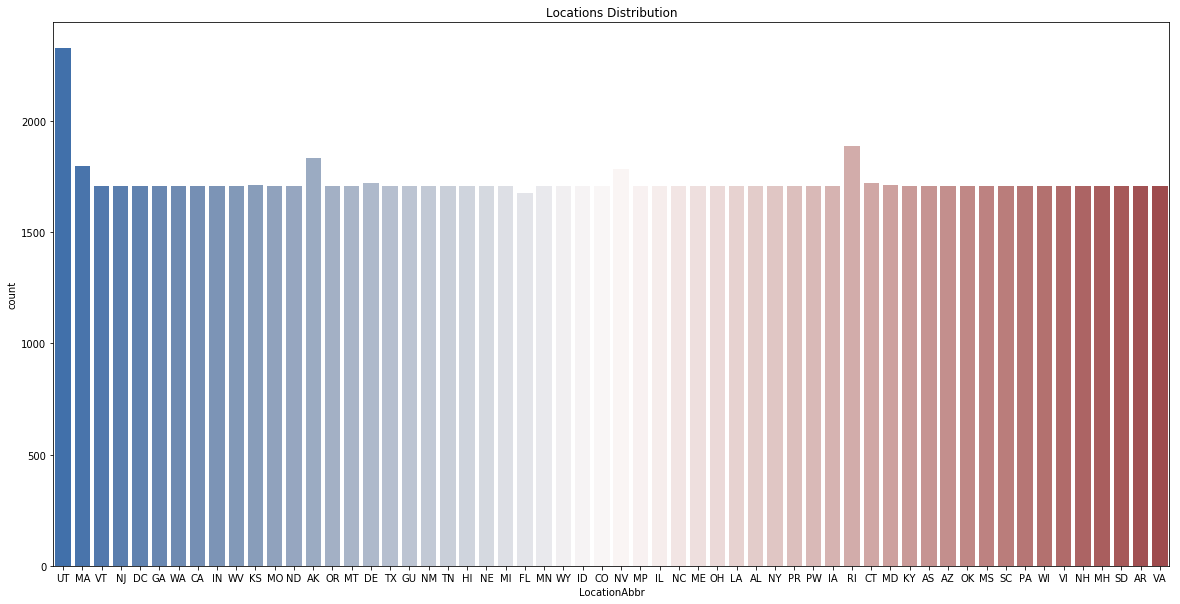

In [12]:
f, ax = plt.subplots(1,1, figsize = (20, 10))
sns.countplot(x=df['LocationAbbr'], ax = ax, palette="vlag")
ax.set_title('Locations Distribution')
plt.show()


### Bar graph showing the number of occurance of the Measure Description Distributions.


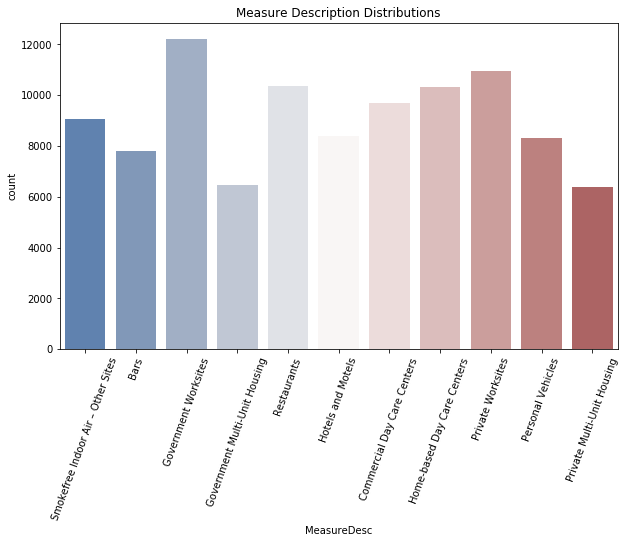

In [13]:
f, ax = plt.subplots(1,1, figsize = (10, 6))
sns.countplot(x=df['MeasureDesc'], ax = ax, palette="vlag")
ax.tick_params('x', rotation = 70)
ax.set_title('Measure Description Distributions')
plt.show()

### Bar graph showing the number of occurance of the Provision Description Distributions.


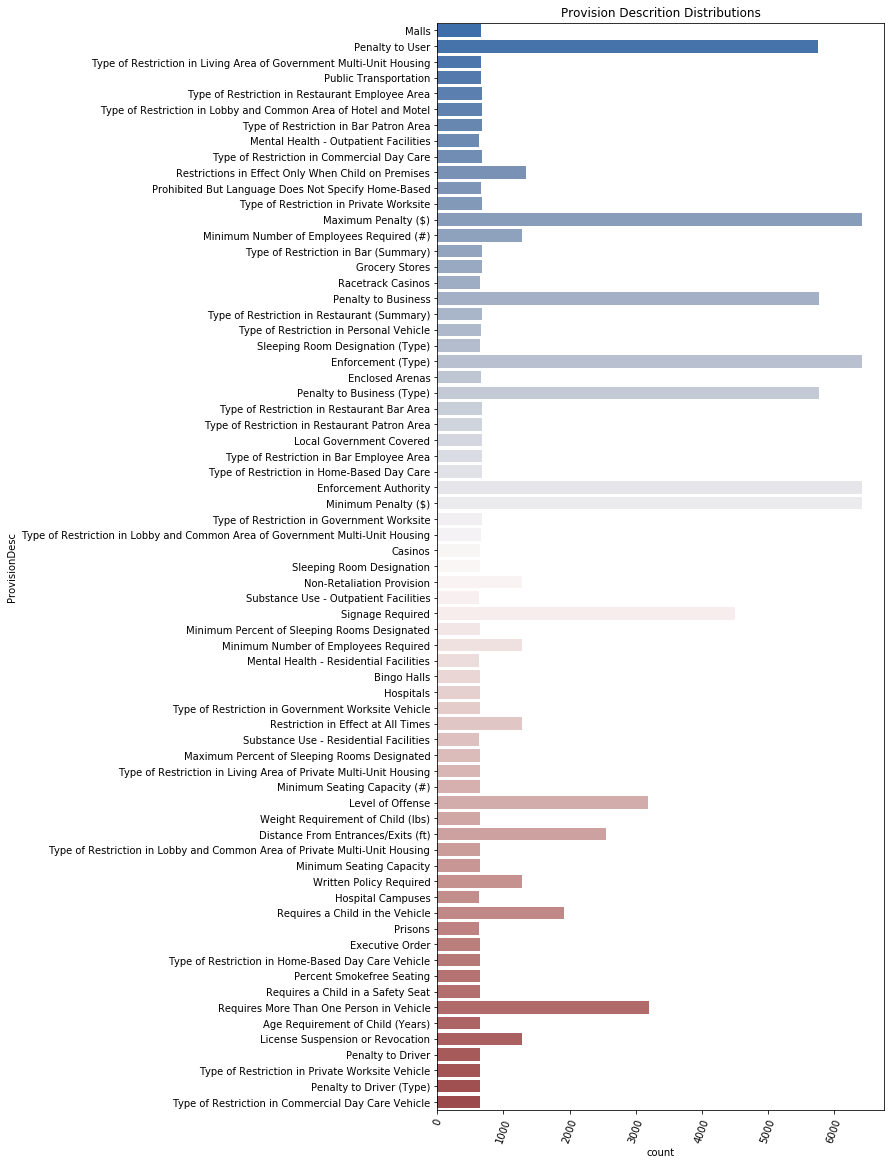

In [14]:
f, ax = plt.subplots(1,1, figsize = (8, 20))
sns.countplot(y=df['ProvisionDesc'], ax = ax, palette="vlag")
ax.tick_params('x', rotation = 70)
ax.set_title('Provision Descrition Distributions')
plt.show()

### Determining Optimum Clusters using the Elbow method for K-means


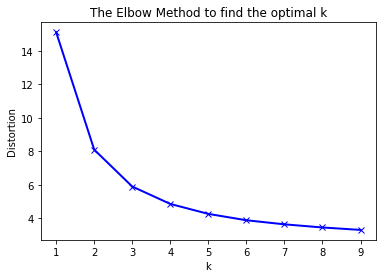

In [15]:
distortions=[]
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(cdf)
    kmeans.fit(cdf)
    distortions.append(sum(np.min(cdist(cdf, kmeans.cluster_centers_, 'euclidean'), axis=1)) / cdf.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-', linewidth=2)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method to find the optimal k')
plt.show()



### From the above elbow method plot, the number of optimal clusters N selected is 4


In [16]:
N = 4
print('Selecting optimum N value =', N)
print('Found distortion from elbow method for',N, 'clusters =', distortions[N-1])



Selecting optimum N value = 4
Found distortion from elbow method for 4 clusters = 4.863603940198783


### Function to plot the clusters


In [0]:
def plot_figure(cdf_col1, cdf_col2,labels,centroids=[]):    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 8))
    plt.scatter(cdf_col1, cdf_col2, c=labels, cmap='rainbow', s = 10)
    if len(centroids) > 0:
        plt.scatter(centroids[:, 0], centroids[:, 1], s = 100, c = 'black', label = 'Centroids', marker = 'o')
        plt.legend(loc=(1.05,0.5))
    plt.xlabel(cdf_col1.name)
    plt.ylabel(cdf_col2.name)
    plt.show()


### Implementing K-means algorithm in TensorFlow framework


In [0]:
def k_means_clustering_tensor_flow(df_col_1, df_col_2, clusters, steps=100):

    vec_vals = []
    for i in range(len(df_col_1)):
        a = df_col_1[i]
        b = df_col_2[i]
        vec_vals.append([a, b])
    v_vals = np.array(vec_vals)
    
    t0 = time()

    sess = tf.Session()
    k = clusters
    points = v_vals
    data = tf.constant(points)   
    centroids = tf.Variable(data[:k, :])
    data_expanded = tf.expand_dims(data, 0)
    centroids_expanded = tf.expand_dims(centroids, 1)

    allocations = tf.argmin(tf.reduce_sum(tf.square(data_expanded - centroids_expanded), 2), 0)
    sess.run(tf.global_variables_initializer())
    c = 0
    tf.equal(allocations, c)
    tf.gather(data, tf.where(tf.equal(allocations, c)))

    means = tf.concat(
        [tf.reduce_mean(
            tf.gather(data,
                      tf.where(tf.equal(allocations, c))), 0) for c in range(k)], 0)

    update_centroids = tf.assign(centroids, means)

    for step in range(steps):
        _, centroid_values, allocation_values = sess.run([update_centroids, centroids, allocations])

        clusters_df = pd.DataFrame({df_col_1.name: points[:,0], df_col_2.name: points[:,1], "cluster": allocation_values})

    train_time = time() - t0
    print("\nTime taken to train with KMeans Model using Tensor Flow is %0.2f seconds" % train_time)

    plot_figure(df_col_1, df_col_2, allocation_values, centroid_values)

### K Means clustering using tensor flow with clusters N calculated from elbow method


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Time taken to train with KMeans Model using Tensor Flow is 1.67 seconds


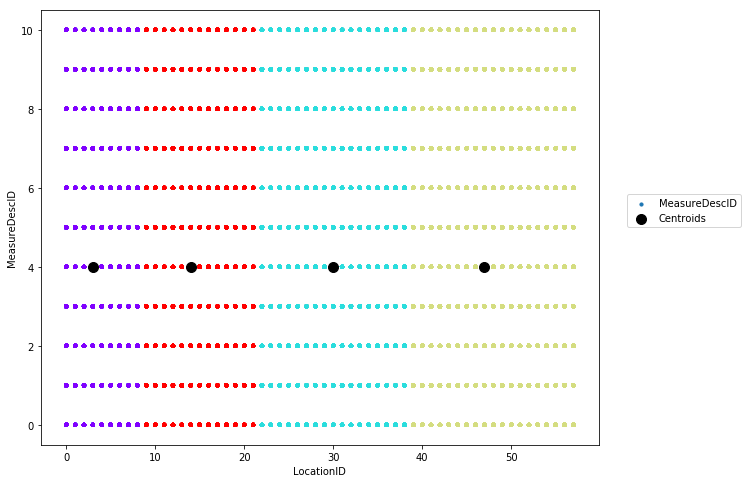

In [19]:
k_means_clustering_tensor_flow(cdf[df_col_value_1], cdf[df_col_value_2], N, 100)



### Clustering performance evaluation for K-means, GMM and Mini-batch Kmeans

#### Metrics Name	  
Adjusted Rand index<br/>
Mutual Information based scores<br/>
Homogeneity, completeness and V-measure<br/>
Fowlkes-Mallows scores<br/>
Calinski-Harabaz Index<br/>
Davies-Bouldin Index<br/>
Contingency Matrix<br/>

Initializing `metricsdf` for calculating metrics 


In [20]:
metricsdf = pd.DataFrame(index=['KMEANS','GMM', 'MBK'], 
                         columns=['ARI','MI','HCV','FM','CH','DB'])

XX = cdf[df_col_value_1]
YY = cdf[df_col_value_2]

# intially all cells are NaN
metricsdf


,ARI,MI,HCV,FM,CH,DB
KMEANS,NaN,NaN,NaN,NaN,NaN,NaN
GMM,NaN,NaN,NaN,NaN,NaN,NaN
MBK,NaN,NaN,NaN,NaN,NaN,NaN


### Function for the performace evaluation for related metrics for KMEANS, GMM, and Mini-batch K-means


In [0]:
def calcMetrics(algorithm):
    # Get metrics data for the algorithms
    metricsdf.loc[algorithm,'ARI'] = metrics.adjusted_rand_score(YY, labels)
    metricsdf.loc[algorithm,'MI']  = metrics.adjusted_mutual_info_score(YY, labels)
    metricsdf.loc[algorithm,'HCV'] = metrics.homogeneity_score(YY, labels)
    metricsdf.loc[algorithm,'FM'] = metrics.fowlkes_mallows_score(YY, labels)
    metricsdf.loc[algorithm,'CH'] = metrics.calinski_harabasz_score(cdf, labels)
    metricsdf.loc[algorithm,'DB'] = metrics.davies_bouldin_score(cdf, labels)
    return


### Implementing Gaussian Mixture  Model in Scikit learn framework



Time taken to train with GMM Model is 0.53 seconds


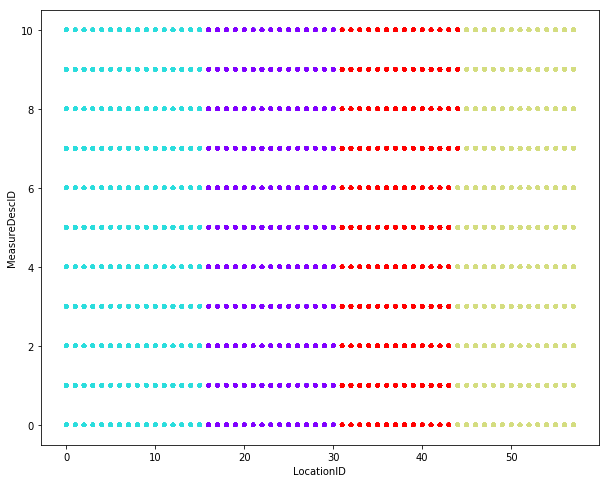

In [22]:
# N is taken from elbow method that was found using k-means
gmm = mixture.GaussianMixture(n_components=N, covariance_type='tied', random_state = 0)
t0 = time()
gmm.fit(cdf)
train_time = time() - t0
print("\nTime taken to train with GMM Model is %0.2f seconds" % train_time)
labels = gmm.predict(cdf)
calcMetrics('GMM')
plot_figure(cdf[df_col_value_1], cdf[df_col_value_2], labels)



### Implementation of Mini Batch KMeans alogorithm using Scikit learn framework



Time taken to train with MiniBatchKMeans Model is 0.56 seconds


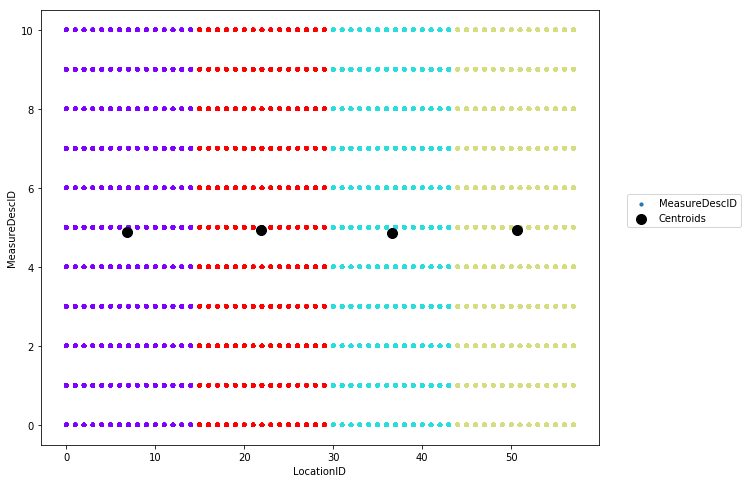

In [23]:
from sklearn.cluster import MiniBatchKMeans

mbk = MiniBatchKMeans(init='k-means++', n_clusters=4, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0)
t0 = time()
mbk.fit(cdf)
t_mini_batch = time() - t0
print("\nTime taken to train with MiniBatchKMeans Model is %0.2f seconds" % t_mini_batch)
labels = mbk.labels_
centroids = mbk.cluster_centers_
calcMetrics('MBK')

plot_figure(cdf[df_col_value_1], cdf[df_col_value_2], labels, centroids)

### Implementation of K-means algorithm using Scikit learn framework



Time taken to train with KMeans Model using ScikitLearn is 0.73 seconds


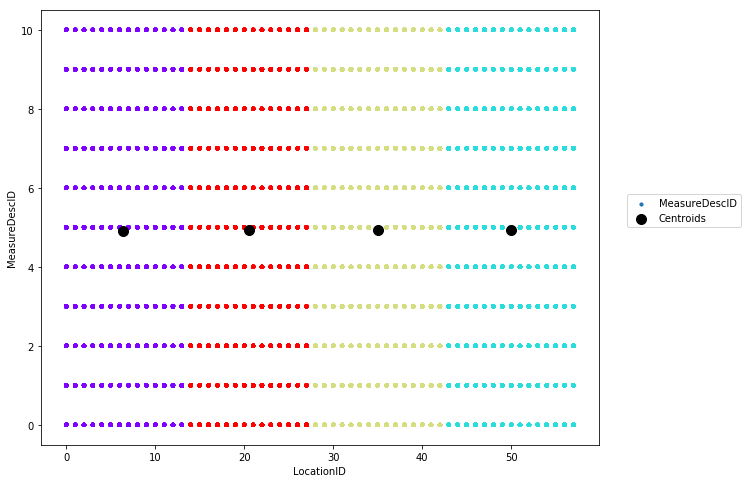

In [24]:
# Using number of clusters N

kmeans = KMeans(init='k-means++', n_clusters = N, random_state = 0, max_iter = 500)
t0 = time()
kmeans.fit(cdf)
train_time = time() - t0
print("\nTime taken to train with KMeans Model using ScikitLearn is %0.2f seconds" % train_time)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
calcMetrics('KMEANS')
plot_figure(cdf[df_col_value_1], cdf[df_col_value_2], labels, centroids)


### Clustering performance evaluation - KMEANS, GMM, Mini Batch Kmeans


In [25]:
print('\nCompare performance of the Scikit Learn Clustering Models')
print('As we can see, KMEANS, Mini Batch Kmeans are almost same and better than GMM')
metricsdf


Compare performance of the Scikit Learn Clustering Models
As we can see, KMEANS, Mini Batch Kmeans are almost same and better than GMM


,ARI,MI,HCV,FM,CH,DB
KMEANS,-3.94674e-05,-5.43826e-05,8.67671e-06,0.153558,326309,0.669526
GMM,4.01811e-05,5.85707e-05,0.000121623,0.15409,322174,0.675562
MBK,-3.96864e-05,-5.54208e-05,7.63855e-06,0.153622,326022,0.670351


### Function for identifying top three values in each cluster for LocationDesc, ProvisionValue, ProvisionDesc, ProvisionGroupDesc, and MeasureDesc attributes.


In [0]:
def findTopInEachCluster(x, col, data, clusters, n):
    top_lists = [dict() for i in range(n)]
    c = 0
    
    for index, row in data.iterrows():
        i = clusters[c]
        c += 1
        if row[col] in top_lists[i]:
            top_lists[i][row[col]] += 1
        else:
             top_lists[i][row[col]] = 1
    
    title = 'Top ' + str(x) + ' ' + str(col) + ' in each cluster' 
    VAR1 = list()
    VAR2 = list()
    print(title)
    for i in range(n):
        print('\nCluster ', i)
        sorted_list = sorted(top_lists[i].items(), key=lambda kv: kv[1])
        sorted_list = list(reversed(sorted_list))
        var1 = list()
        var2 = list()
        for y in range(x):
            #print(str(y+1) + '. ' + str(sorted_list[y]))
            print(str(y+1) + '. (' + col + ', Count) = ' + str(sorted_list[y]))
            var1.append(sorted_list[y][0])
            var2.append(sorted_list[y][1])
        VAR1.append(var1)
        VAR2.append(var2)
    
    plt.figure(figsize=(10, 10))
    plt.suptitle(title, fontsize=20)
    colorlist = ['b', 'r', 'g', 'c', 'm', 'y']
    for i in range(n):
        plt.subplot(221+i)
        plt.bar(VAR1[i],VAR2[i], width = 0.25, color=colorlist[i])
        plt.xticks(rotation=45)
        titlestr = 'Cluster ' + str(i)
        plt.title(titlestr, fontsize=10)
    plt.show()
    
    return

top_x = 3

### Top Locations in each Cluster

Top 3 LocationDesc in each cluster

Cluster  0
1. (LocationDesc, Count) = ('Utah', 2326)
2. (LocationDesc, Count) = ('Alaska', 1831)
3. (LocationDesc, Count) = ('Massachusetts', 1797)

Cluster  1
1. (LocationDesc, Count) = ('Maryland', 1709)
2. (LocationDesc, Count) = ('Virginia', 1705)
3. (LocationDesc, Count) = ('Arkansas', 1705)

Cluster  2
1. (LocationDesc, Count) = ('Rhode Island', 1885)
2. (LocationDesc, Count) = ('Nevada', 1782)
3. (LocationDesc, Count) = ('Connecticut', 1718)

Cluster  3
1. (LocationDesc, Count) = ('Delaware', 1718)
2. (LocationDesc, Count) = ('Hawaii', 1708)
3. (LocationDesc, Count) = ('Idaho', 1705)


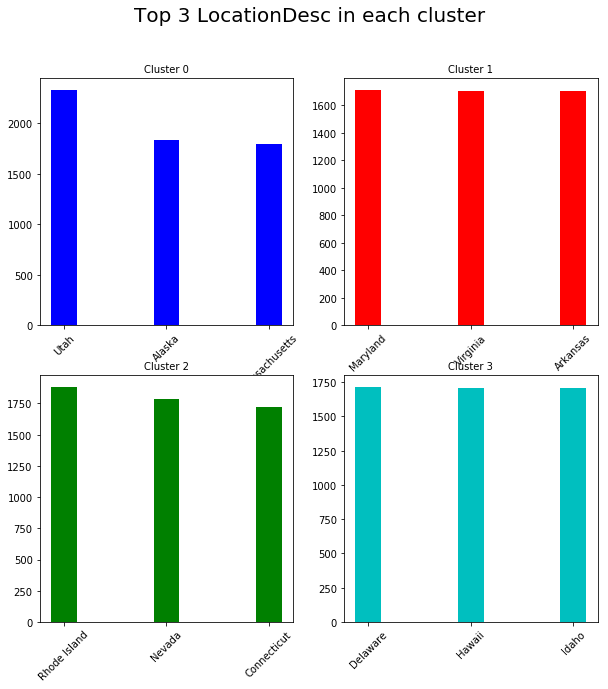

In [27]:
findTopInEachCluster(top_x, 'LocationDesc', df, labels, N)

### Top ProvisionValue in each Cluster


Top 3 ProvisionValue in each cluster

Cluster  0
1. (ProvisionValue, Count) = ('No Provision', 22020)
2. (ProvisionValue, Count) = ('Banned', 993)
3. (ProvisionValue, Count) = ('Yes', 870)

Cluster  1
1. (ProvisionValue, Count) = ('No Provision', 25500)
2. (ProvisionValue, Count) = ('Yes', 32)
3. (ProvisionValue, Count) = ('Banned', 30)

Cluster  2
1. (ProvisionValue, Count) = ('No Provision', 23664)
2. (ProvisionValue, Count) = ('Yes', 773)
3. (ProvisionValue, Count) = ('Banned', 528)

Cluster  3
1. (ProvisionValue, Count) = ('No Provision', 22479)
2. (ProvisionValue, Count) = ('Yes', 485)
3. (ProvisionValue, Count) = ('Banned', 307)


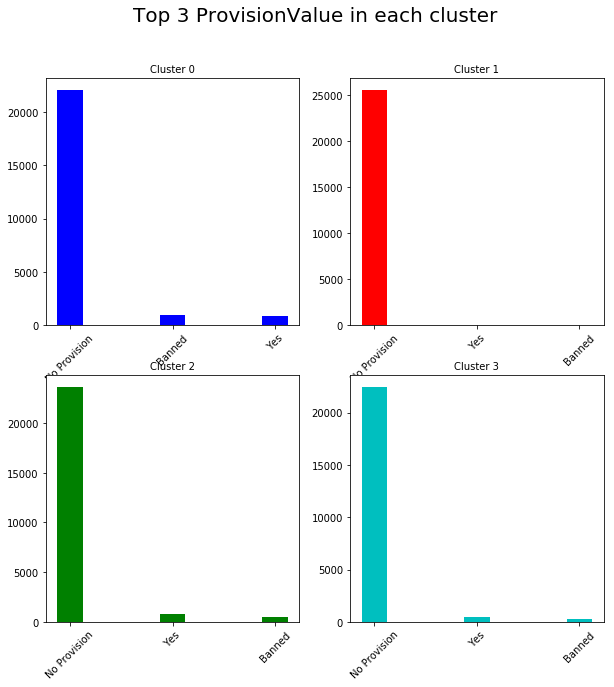

In [28]:
findTopInEachCluster(top_x, 'ProvisionValue', df, labels, N)

### Top Provision Descriptions in each Cluster

Top 3 ProvisionDesc in each cluster

Cluster  0
1. (ProvisionDesc, Count) = ('Minimum Penalty ($)', 1556)
2. (ProvisionDesc, Count) = ('Enforcement Authority', 1556)
3. (ProvisionDesc, Count) = ('Maximum Penalty ($)', 1556)

Cluster  1
1. (ProvisionDesc, Count) = ('Maximum Penalty ($)', 1651)
2. (ProvisionDesc, Count) = ('Minimum Penalty ($)', 1651)
3. (ProvisionDesc, Count) = ('Enforcement Authority', 1650)

Cluster  2
1. (ProvisionDesc, Count) = ('Enforcement (Type)', 1677)
2. (ProvisionDesc, Count) = ('Enforcement Authority', 1675)
3. (ProvisionDesc, Count) = ('Maximum Penalty ($)', 1671)

Cluster  3
1. (ProvisionDesc, Count) = ('Maximum Penalty ($)', 1554)
2. (ProvisionDesc, Count) = ('Minimum Penalty ($)', 1541)
3. (ProvisionDesc, Count) = ('Enforcement Authority', 1540)


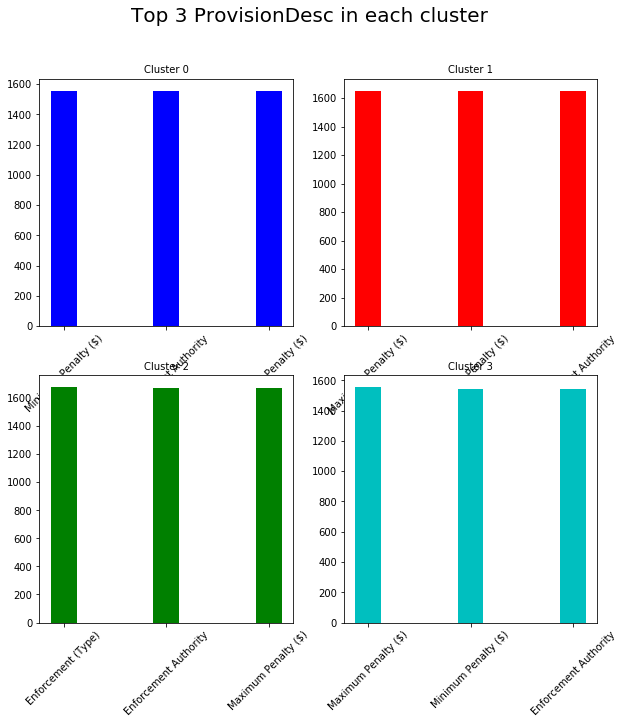

In [29]:
findTopInEachCluster(top_x, 'ProvisionDesc', df, labels, N)


### Top Provision Group Descriptions in each Cluster

Top 3 ProvisionGroupDesc in each cluster

Cluster  0
1. (ProvisionGroupDesc, Count) = ('Penalties', 7935)
2. (ProvisionGroupDesc, Count) = ('Enforcement', 4200)
3. (ProvisionGroupDesc, Count) = ('Restriction Areas', 3810)

Cluster  1
1. (ProvisionGroupDesc, Count) = ('Penalties', 8419)
2. (ProvisionGroupDesc, Count) = ('Enforcement', 4455)
3. (ProvisionGroupDesc, Count) = ('Restriction Areas', 3795)

Cluster  2
1. (ProvisionGroupDesc, Count) = ('Penalties', 8506)
2. (ProvisionGroupDesc, Count) = ('Enforcement', 4527)
3. (ProvisionGroupDesc, Count) = ('Restriction Areas', 3841)

Cluster  3
1. (ProvisionGroupDesc, Count) = ('Penalties', 7870)
2. (ProvisionGroupDesc, Count) = ('Enforcement', 4158)
3. (ProvisionGroupDesc, Count) = ('Restriction Areas', 3526)


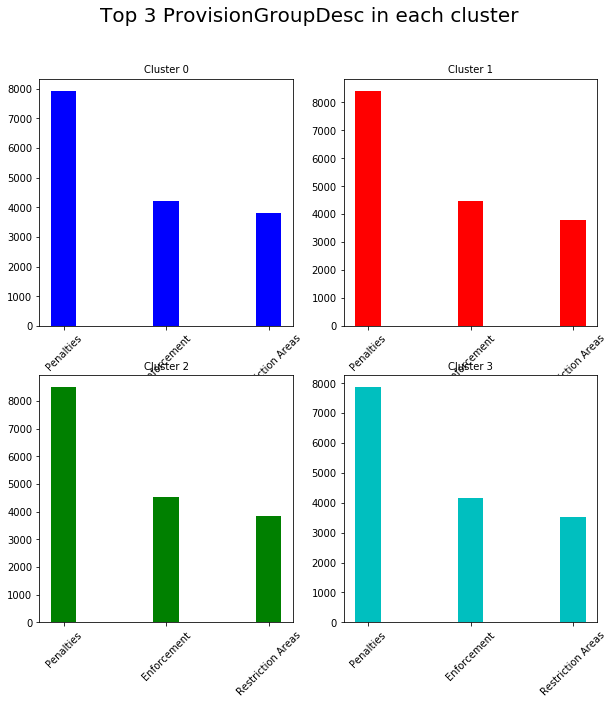

In [30]:
findTopInEachCluster(top_x, 'ProvisionGroupDesc', df, labels, N)

### Top Measure Descriptions in each Cluster

Top 3 MeasureDesc in each cluster

Cluster  0
1. (MeasureDesc, Count) = ('Government Worksites', 3005)
2. (MeasureDesc, Count) = ('Private Worksites', 2674)
3. (MeasureDesc, Count) = ('Restaurants', 2593)

Cluster  1
1. (MeasureDesc, Count) = ('Government Worksites', 3135)
2. (MeasureDesc, Count) = ('Private Worksites', 2805)
3. (MeasureDesc, Count) = ('Home-based Day Care Centers', 2640)

Cluster  2
1. (MeasureDesc, Count) = ('Government Worksites', 3168)
2. (MeasureDesc, Count) = ('Private Worksites', 2837)
3. (MeasureDesc, Count) = ('Restaurants', 2675)

Cluster  3
1. (MeasureDesc, Count) = ('Government Worksites', 2924)
2. (MeasureDesc, Count) = ('Private Worksites', 2630)
3. (MeasureDesc, Count) = ('Home-based Day Care Centers', 2462)


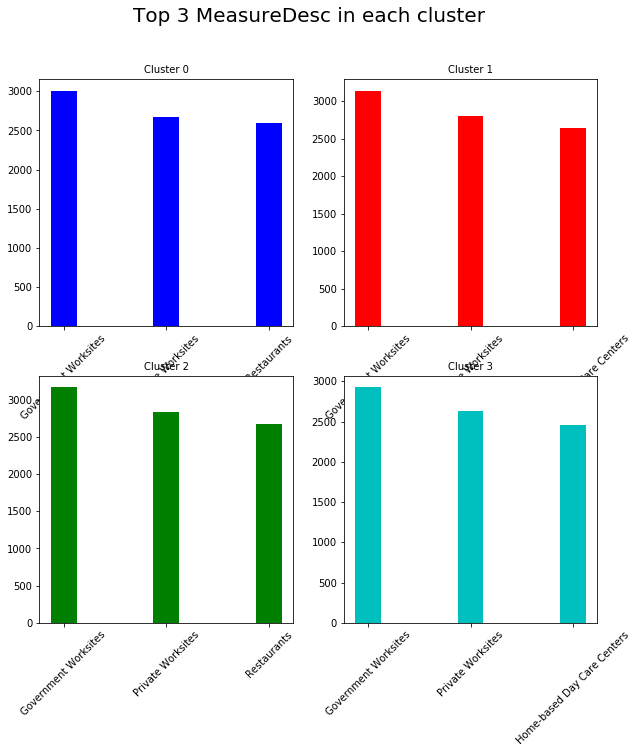

In [31]:
findTopInEachCluster(top_x, 'MeasureDesc', df, labels, N)

### Create data frame for map plotting

In [32]:


#rdf = df.groupby(["LocationID", "Latitude", "Longitude", "MeasureDesc"]).size().reset_index(name="Restricted")
rdf = df.groupby(["LocationID", "MeasureDesc"]).size().reset_index(name="Restricted")

indexNames = rdf[(rdf['MeasureDesc'] != "Bars") & (rdf['MeasureDesc'] != "Restaurants") & (rdf['MeasureDesc'] != "Government Worksites") & (rdf['MeasureDesc'] != "Private Worksites")].index
rdf.drop(indexNames , inplace=True)
print(rdf.shape)
print(rdf.head())


bannedList = ['Bars', 'Restaurants', 'Government Worksites', 'Private Worksites']

ndf = pd.DataFrame(rdf.LocationID.unique(), columns =['LocationID'])
for bl in bannedList:
  ndf[bl] = 0

locList = ndf.LocationID.unique().tolist()

for ll in locList:
    for bl in bannedList:
        try:
          val = rdf.loc[(rdf['LocationID'] == ll) & (rdf['MeasureDesc'] == bl), 'Restricted'].values[0]
          rowindex = getRowIndex(ndf, ll)
          if rowindex != -1:
            ndf.set_value(rowindex, bl, val)
          else:
            print(False, ndf.at[ll, 'LocationID'])
        except:
          ndf.set_value(rowindex, bl, 0)

ndf = ndf.fillna(0)

ndf.head()




(232, 3)
    LocationID           MeasureDesc  Restricted
0            0                  Bars         213
3            0  Government Worksites         263
8            0     Private Worksites         214
9            0           Restaurants         284
11           1                  Bars         143


,LocationID,Bars,Restaurants,Government Worksites,Private Worksites
0,0,213,284,263,214
1,1,143,188,223,199
2,2,132,176,209,187
3,3,132,176,209,187
4,4,132,176,209,187


### Total Restricted count of Bars, Restaurants, Worksites are calculated

In [33]:
for bl in bannedList:        
  ndf[bl] = pd.to_numeric(ndf[bl], errors='ignore')          

ndf['Restricted'] = ndf['Bars'] + ndf['Restaurants'] + ndf['Government Worksites'] + ndf['Private Worksites']

ndf['Latitude'] = ''
ndf['Longitude'] = ''


loc = ndf['LocationID'].unique().tolist()
locMapping = dict( zip(loc,range(len(loc))) )

print(locationIndexList)
print(latitudeIndexList)
print(longitudeIndexList)
print(locAbbrIndexList)


for ll in locList:
    locidxval = locationIndexList[ll]
    locidxvalndf = locList.index(ll)
    latval = latitudeIndexList[locidxval]
    lonval = longitudeIndexList[locidxval]
    abbval = locAbbrIndexList[locidxval]
    ndf.set_value(locidxvalndf, 'Latitude', latval )
    ndf.set_value(locidxvalndf, 'Longitude', lonval )
    ndf.set_value(locidxvalndf, 'LocationAbbr', abbval )
    
#ndf.sort_values('Restricted',ascending = True).head(100)
ndf.head(100)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
[39.360700171000474, 42.27687047000046, 43.62538123900049, 40.13057004800049, 38.89037138500049, 32.83968109300048, 47.52227862900048, 37.63864012300047, 39.766910452000445, 38.66551020200046, 38.34774030000045, 38.635790776000476, 47.47531977900047, 64.84507995700051, 44.56744942400047, 47.06652897200047, 39.008830667000495, 31.827240407000488, 13.444304, 34.52088095200048, 35.68094058000048, 21.304850435000446, 41.6410409880005, 44.6613195430005, 28.932040377000476, 46.35564873600049, 43.23554134300048, 43.682630005000476, 38.843840757000464, 39.493240390000494, 15.0979, 40.48501028300046, 35.466220975000454, 45.254228894000505, 40.06021014100048, 31.31266064400046, 32.84057112200048, 42.82700103200045, 18.220833, 7.514979999999999, 42.46940091300047, 41.7082801930

,LocationID,Bars,Restaurants,Government Worksites,Private Worksites,Restricted,Latitude,Longitude,LocationAbbr
0,0,213,284,263,214,974,39.3607,-111.587,UT
1,1,143,188,223,199,753,42.2769,-72.0827,MA
2,2,132,176,209,187,704,43.6254,-72.5176,VT
3,3,132,176,209,187,704,40.1306,-74.2737,NJ
4,4,132,176,209,187,704,38.8904,-77.032,DC
5,5,132,176,209,187,704,32.8397,-83.6276,GA
6,6,132,176,209,187,704,47.5223,-120.47,WA
7,7,132,176,209,187,704,37.6386,-121,CA
8,8,132,176,209,187,704,39.7669,-86.15,IN
9,9,132,176,209,187,704,38.6655,-80.7126,WV


### Comprehensive = Restricted in worksites, restaurants, and bars as of Q3 2019 Interactive Map Plot

In [34]:
for col in ndf.columns:
    ndf[col] = ndf[col].astype(str)

ndf['text'] = ndf['LocationAbbr'] + '<br>' + \
    'Bars: ' + ndf['Bars'] + '<br>' + 'Restaurants: ' + ndf['Restaurants'] + '<br>' + \
    'Government Worksites: ' + ndf['Government Worksites'] + '<br>' + 'Private Worksites: ' + ndf['Private Worksites'] + '<br>'

fig = go.Figure(data=go.Choropleth(
    locations=ndf['LocationAbbr'],
    z=ndf['Restricted'].astype(float),
    locationmode='USA-states',
    colorscale='Earth',
    zmin = min(ndf['Restricted'].astype(float)) - 0,
    zmax = max(ndf['Restricted'].astype(float)),
    autocolorscale=False,
    text=ndf['text'], # hover text
    marker_line_color='white', # line markers between states
    colorbar_title="Restricted"
))

fig.update_layout(
    title_text='Comprehensive = Restricted in worksites, restaurants, and bars as of Q3 2019.<br>(Hover for breakdown)',
    autosize=False,
    width=1200,
    height=800,
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()

### Clusters Analysis

The clustering is done based on the `Location` and the `Measurement Description` at each location. KMeans Clusetring method is performed for the data frames using both Tensor Flow and Scikit learn frameworks. GMM clusering and Mini Batch K-Means clustering are run using Scikit learn method. The clustering data set had 2 columns and nearly 100k rows. Using elbow method the optimum clusers are selected as N=4. The clusters are well defined and are visualized using the matlab scatter plots. Also the `Scikit Learn Metrics` are calculated to compare the clustering methods and it is found for this data set for 100K rows, the KMEANS algorithm is better than GMM or Mini Batch KMEANS. <br/>



### Graph Analysis

Top three for the parameters (LocationDesc, ProvisionValue, ProvisionDesc, ProvisionGroupDesc, and MeasureDesc) per cluster are found and visualized using the bar chart plots. Here are the observances that were found.

1. In all the clusters, there are highly no provisions for e-cigarette compared to either banned or allowed occurances. Eg: in Cluster 0 if 22k occurances are no provisions then only 900 are allowed and 1k are banned. 
2. In Cluster 0 belonging to states Utah, Alaska, Massechussets there are more number of penalties for e-cigarette usage.
3. In Cluster 0 states, e-cigarette usages are high in Worksites and Restaurants. 


### Map Analysis, New develpments and Insights

An interactive map as of Q3 2019 is visualized using Matlab Plotly Choropleth displaying USA States. Total Restricted count that is sum of Measure Description Parameters of Bars, Restaurants, Government Worksites and Private Worksites are calculated per state. This data is displayed when hovering over each state on the USA Map. For the data selected with 100K rows, following insights can be noticed.

1. All states have restrictions to some extent.
2. State Utah tops the list. 
3. Next states are Nevada, Massechussets.
4. Almost all the remaining have nearly same usage and restrictions from this dataset. 